## Data loading

### Subtask:
Load the data from the "playstore_reviews_india.csv" file into a pandas DataFrame.


In [1]:
import pandas as pd

try:
    df = pd.read_csv('playstore_reviews_india4.csv')
    display(df.head())
    print(df.shape)
except FileNotFoundError:
    print("Error: 'playstore_reviews_india.csv' not found.")
except pd.errors.ParserError:
    print("Error: Could not parse the CSV file. Please check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

,app_id,review,rating,date,thumbsUp
0,com.gen.bettermeditation,"They just want your money! Once I subscribed, ...",1,2024-08-24 20:26:11,7
1,com.gen.bettermeditation,I can't access any of the meditations besides ...,4,2025-01-22 10:34:09,11
2,com.gen.bettermeditation,I want to like this. But I don't think it's wo...,3,2025-01-21 22:16:05,0
3,com.gen.bettermeditation,The meditations in this app are very low quali...,2,2024-12-25 09:34:15,1
4,com.gen.bettermeditation,New to the app. It looks well thought out. The...,4,2024-12-31 19:44:08,12


(216113, 5)


## Data cleaning

### Subtask:
Clean the text data within the 'review' column of the DataFrame `df`.


In [2]:
import re

# 1. Handle missing values
print(f"Number of missing reviews before handling: {df['review'].isnull().sum()}")
df['review'].fillna("No review text provided.", inplace=True)
print(f"Number of missing reviews after handling: {df['review'].isnull().sum()}")

# 2. Remove noise
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special symbols and irrelevant characters
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['review'] = df['review'].apply(clean_text)

# 3. Lowercase the text
df['review'] = df['review'].str.lower()

# 4. Remove duplicates (Optional)
print(f"Number of duplicated reviews before removal: {df.duplicated(subset=['review']).sum()}")
df.drop_duplicates(subset=['review'], inplace=True)
print(f"Number of duplicated reviews after removal: {df.duplicated(subset=['review']).sum()}")

display(df.head())

Number of missing reviews before handling: 83
Number of missing reviews after handling: 0


<ipython-input-2-beb9890444dd>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['review'].fillna("No review text provided.", inplace=True)


Number of duplicated reviews before removal: 26309
Number of duplicated reviews after removal: 0


,app_id,review,rating,date,thumbsUp
0,com.gen.bettermeditation,they just want your money once i subscribed ev...,1,2024-08-24 20:26:11,7
1,com.gen.bettermeditation,i cant access any of the meditations besides a...,4,2025-01-22 10:34:09,11
2,com.gen.bettermeditation,i want to like this but i dont think its worth...,3,2025-01-21 22:16:05,0
3,com.gen.bettermeditation,the meditations in this app are very low quali...,2,2024-12-25 09:34:15,1
4,com.gen.bettermeditation,new to the app it looks well thought out they ...,4,2024-12-31 19:44:08,12


## Data preparation

### Subtask:
Prepare the cleaned text data for subsequent analysis (sentiment analysis, keyword extraction, and named entity recognition).


In [3]:
import nltk
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data if not already present (This might be redundant, but ensures all needed data is there)
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word for word in words if word.isalnum() and word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['processed_review'] = df['review'].apply(preprocess_text)
display(df.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,app_id,review,rating,date,thumbsUp,processed_review
0,com.gen.bettermeditation,they just want your money once i subscribed ev...,1,2024-08-24 20:26:11,7,want money subscribed everything basic could g...
1,com.gen.bettermeditation,i cant access any of the meditations besides a...,4,2025-01-22 10:34:09,11,cant access meditation besides anxiety anytime...
2,com.gen.bettermeditation,i want to like this but i dont think its worth...,3,2025-01-21 22:16:05,0,want like dont think worth pay month isnt much...
3,com.gen.bettermeditation,the meditations in this app are very low quali...,2,2024-12-25 09:34:15,1,meditation app low quality voiced ai content f...
4,com.gen.bettermeditation,new to the app it looks well thought out they ...,4,2024-12-31 19:44:08,12,new app look well thought show different possi...


## Data analysis

### Subtask:
Perform sentiment analysis, keyword extraction, and named entity recognition on the preprocessed review data.


In [4]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy


# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores

df['sentiment_scores'] = df['processed_review'].apply(analyze_sentiment)

# Keyword Extraction
vectorizer = TfidfVectorizer(max_features=10) # Adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(df['processed_review'])

# Get feature names (keywords)
feature_names = vectorizer.get_feature_names_out()
# Convert the matrix to a dense array
dense_matrix = tfidf_matrix.toarray()

df['keywords'] = [list(feature_names[idx]) for idx in dense_matrix.argsort(axis=1)[:,-10:][:,::-1]]


# Named Entity Recognition
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000
def extract_entities(text):
  doc = nlp(text)
  entities = [(ent.text, ent.label_) for ent in doc.ents]
  return entities

def extract_entities_limited(text, max_chars=2000000):
    text = text[:max_chars]  # Truncate text if it's too long
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

df['named_entities'] = df['processed_review'].apply(extract_entities_limited)

display(df.head())

,app_id,review,rating,date,thumbsUp,processed_review,sentiment_scores,keywords,named_entities
0,com.gen.bettermeditation,they just want your money once i subscribed ev...,1,2024-08-24 20:26:11,7,want money subscribed everything basic could g...,"{'neg': 0.185, 'neu': 0.784, 'pos': 0.031, 'co...","[day, get, really, love, like, im, help, great...","[(4 day ago, DATE)]"
1,com.gen.bettermeditation,i cant access any of the meditations besides a...,4,2025-01-22 10:34:09,11,cant access meditation besides anxiety anytime...,"{'neg': 0.088, 'neu': 0.699, 'pos': 0.212, 'co...","[app, great, really, love, like, im, help, goo...","[(12225, DATE)]"
2,com.gen.bettermeditation,i want to like this but i dont think its worth...,3,2025-01-21 22:16:05,0,want like dont think worth pay month isnt much...,"{'neg': 0.083, 'neu': 0.707, 'pos': 0.21, 'com...","[like, im, get, app, really, love, help, great...","[(month, DATE), (month, DATE)]"
3,com.gen.bettermeditation,the meditations in this app are very low quali...,2,2024-12-25 09:34:15,1,meditation app low quality voiced ai content f...,"{'neg': 0.134, 'neu': 0.64, 'pos': 0.226, 'com...","[app, really, love, like, im, help, great, goo...","[(3month, CARDINAL)]"
4,com.gen.bettermeditation,new to the app it looks well thought out they ...,4,2024-12-31 19:44:08,12,new app look well thought show different possi...,"{'neg': 0.061, 'neu': 0.79, 'pos': 0.149, 'com...","[really, app, help, love, like, im, great, goo...","[(daily, DATE)]"


## Feature engineering

### Subtask:
Create new features based on the sentiment analysis, keywords, and named entities.  Categorize behaviors based on custom logic.


In [5]:
import pandas as pd

# 1. Sentiment Features
df['overall_sentiment'] = df['sentiment_scores'].apply(lambda x: 'positive' if x['compound'] >= 0.05 else ('negative' if x['compound'] <= -0.05 else 'neutral'))
df['positive_sentiment'] = df['sentiment_scores'].apply(lambda x: x['pos'])
df['negative_sentiment'] = df['sentiment_scores'].apply(lambda x: x['neg'])
df['neutral_sentiment'] = df['sentiment_scores'].apply(lambda x: x['neu'])

# 2. Keyword Features
# Example keywords (replace with your actual important keywords)
keywords_to_check = ["excellent", "amazing", "bug", "crash", "error"]
for keyword in keywords_to_check:
    df[f"keyword_{keyword}"] = df['processed_review'].str.contains(keyword).astype(int)

# 3. Named Entity Features
df['has_person'] = df['named_entities'].apply(lambda x: 1 if any(ent[1] == 'PERSON' for ent in x) else 0)
df['has_org'] = df['named_entities'].apply(lambda x: 1 if any(ent[1] == 'ORG' for ent in x) else 0)

# 4. Behavioral Categorization
def categorize_behavior(row):
    if row['keyword_bug'] == 1 and row['keyword_crash'] == 1 and row['overall_sentiment'] == 'negative':
        return 'Bug Report'
    elif row['keyword_excellent'] == 1 and row['overall_sentiment'] == 'positive':
        return 'Feature Appreciation'
    elif row['overall_sentiment'] == 'negative':
        return 'Negative Feedback'
    elif row['overall_sentiment'] == 'positive':
        return 'Positive Feedback'
    else:
        return 'Neutral Feedback'

df['behavior_category'] = df.apply(categorize_behavior, axis=1)

display(df.head())

,app_id,review,rating,date,thumbsUp,processed_review,sentiment_scores,keywords,named_entities,overall_sentiment,...,negative_sentiment,neutral_sentiment,keyword_excellent,keyword_amazing,keyword_bug,keyword_crash,keyword_error,has_person,has_org,behavior_category
0,com.gen.bettermeditation,they just want your money once i subscribed ev...,1,2024-08-24 20:26:11,7,want money subscribed everything basic could g...,"{'neg': 0.185, 'neu': 0.784, 'pos': 0.031, 'co...","[day, get, really, love, like, im, help, great...","[(4 day ago, DATE)]",negative,...,0.185,0.784,0,0,0,0,0,0,0,Negative Feedback
1,com.gen.bettermeditation,i cant access any of the meditations besides a...,4,2025-01-22 10:34:09,11,cant access meditation besides anxiety anytime...,"{'neg': 0.088, 'neu': 0.699, 'pos': 0.212, 'co...","[app, great, really, love, like, im, help, goo...","[(12225, DATE)]",positive,...,0.088,0.699,0,0,0,0,0,0,0,Positive Feedback
2,com.gen.bettermeditation,i want to like this but i dont think its worth...,3,2025-01-21 22:16:05,0,want like dont think worth pay month isnt much...,"{'neg': 0.083, 'neu': 0.707, 'pos': 0.21, 'com...","[like, im, get, app, really, love, help, great...","[(month, DATE), (month, DATE)]",positive,...,0.083,0.707,0,0,0,0,0,0,0,Positive Feedback
3,com.gen.bettermeditation,the meditations in this app are very low quali...,2,2024-12-25 09:34:15,1,meditation app low quality voiced ai content f...,"{'neg': 0.134, 'neu': 0.64, 'pos': 0.226, 'com...","[app, really, love, like, im, help, great, goo...","[(3month, CARDINAL)]",positive,...,0.134,0.640,0,0,0,0,0,0,0,Positive Feedback
4,com.gen.bettermeditation,new to the app it looks well thought out they ...,4,2024-12-31 19:44:08,12,new app look well thought show different possi...,"{'neg': 0.061, 'neu': 0.79, 'pos': 0.149, 'com...","[really, app, help, love, like, im, great, goo...","[(daily, DATE)]",positive,...,0.061,0.790,0,0,0,1,0,0,0,Positive Feedback


In [6]:
df.to_csv("processed_reviews.csv", index=False)

print("✅ DataFrame saved as 'processed_reviews.csv'")

✅ DataFrame saved as 'processed_reviews.csv'


## Data exploration

### Subtask:
Explore the newly engineered features and their relationships with each other and with other relevant columns in the dataset. Look for patterns and insights.


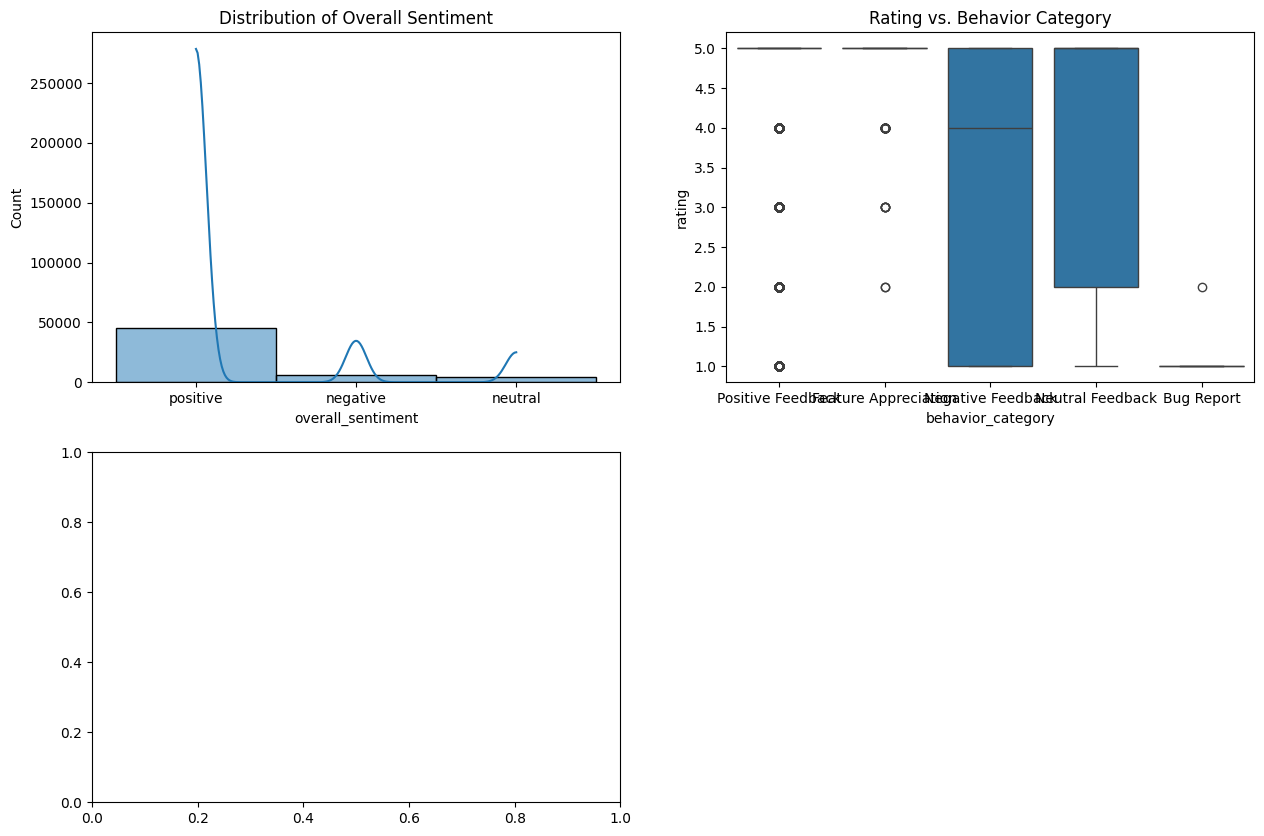

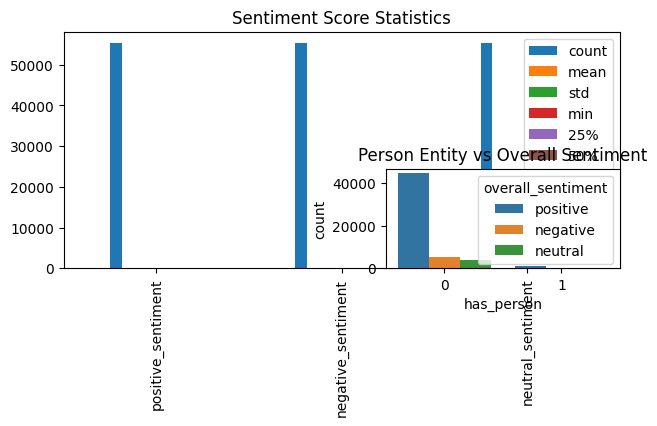

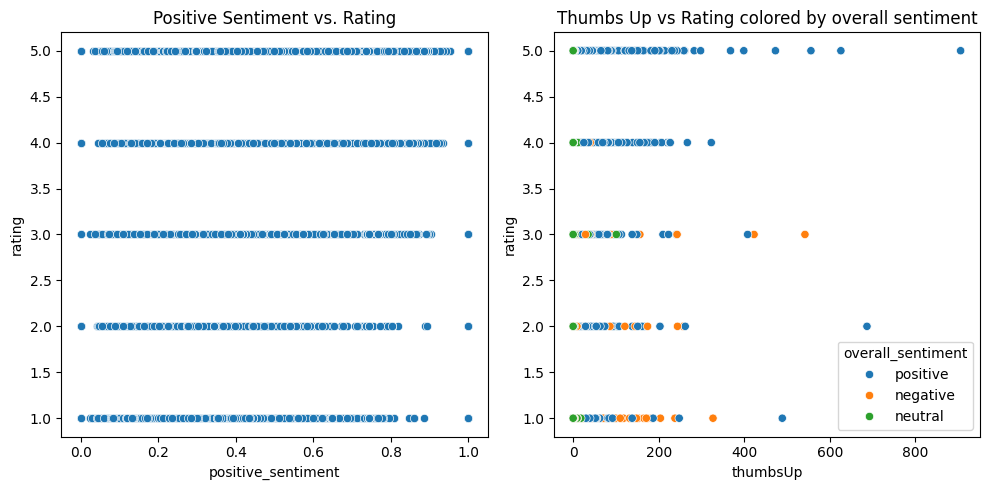

<Figure size 1000x500 with 0 Axes>

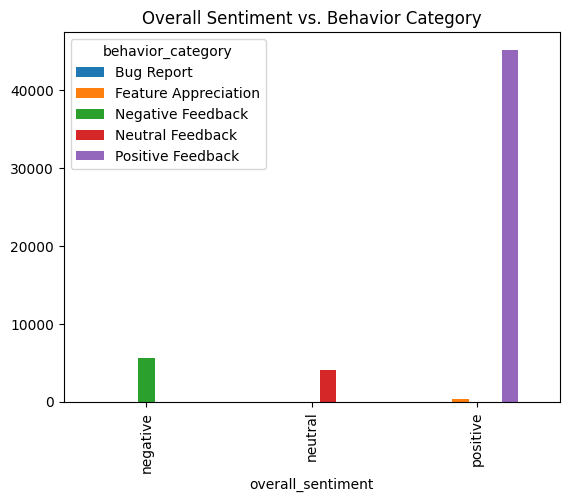

,rating,thumbsUp,positive_sentiment,negative_sentiment,neutral_sentiment,keyword_bug,keyword_crash
rating,1.000000,-0.080109,0.402316,-0.228806,-0.301983,-0.105625,-0.094507
thumbsUp,-0.080109,1.000000,-0.074644,0.032210,0.062616,0.023085,0.014522
positive_sentiment,0.402316,-0.074644,1.000000,-0.432908,-0.830210,-0.065910,-0.055881
negative_sentiment,-0.228806,0.032210,-0.432908,1.000000,-0.135482,0.009984,0.047368
neutral_sentiment,-0.301983,0.062616,-0.830210,-0.135482,1.000000,0.066501,0.032525
keyword_bug,-0.105625,0.023085,-0.065910,0.009984,0.066501,1.000000,0.034713
keyword_crash,-0.094507,0.014522,-0.055881,0.047368,0.032525,0.034713,1.000000


,rating,thumbsUp,positive_sentiment,negative_sentiment,neutral_sentiment,keyword_bug,keyword_crash
count,55323.000000,55323.000000,55323.000000,55323.000000,55323.000000,55323.000000,55323.000000
mean,4.434900,2.000452,0.448598,0.087078,0.463857,0.006815,0.003127
std,1.168964,13.418670,0.246042,0.137136,0.223821,0.082269,0.055833
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.291000,0.000000,0.314000,0.000000,0.000000
50%,5.000000,0.000000,0.453000,0.000000,0.446000,0.000000,0.000000
75%,5.000000,0.000000,0.615000,0.147000,0.588000,0.000000,0.000000
max,5.000000,906.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of engineered features
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(df['overall_sentiment'], kde=True)
plt.title('Distribution of Overall Sentiment')

plt.subplot(2, 2, 2)
sns.boxplot(x='behavior_category', y='rating', data=df)
plt.title('Rating vs. Behavior Category')

plt.subplot(2, 2, 3)
df[["positive_sentiment", "negative_sentiment", "neutral_sentiment"]].describe().T.plot(kind='bar')
plt.title('Sentiment Score Statistics')

plt.subplot(2, 2, 4)
sns.countplot(x='has_person', hue='overall_sentiment', data=df)
plt.title('Person Entity vs Overall Sentiment')
plt.tight_layout()
plt.show()


# 2. Relationships between engineered features and original columns
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='positive_sentiment', y='rating', data=df)
plt.title('Positive Sentiment vs. Rating')

plt.subplot(1, 2, 2)
sns.scatterplot(x='thumbsUp', y='rating', hue='overall_sentiment', data=df)
plt.title('Thumbs Up vs Rating colored by overall sentiment')
plt.tight_layout()
plt.show()

# 3. Interactions between engineered features
plt.figure(figsize=(10, 5))
pd.crosstab(df['overall_sentiment'], df['behavior_category']).plot(kind='bar')
plt.title('Overall Sentiment vs. Behavior Category')
plt.show()

# 4. Correlation matrix
correlation_matrix = df[['rating', 'thumbsUp', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'keyword_bug', 'keyword_crash']].corr()
display(correlation_matrix)

# Display some descriptive statistics
display(df[['rating', 'thumbsUp', 'positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'keyword_bug', 'keyword_crash']].describe())

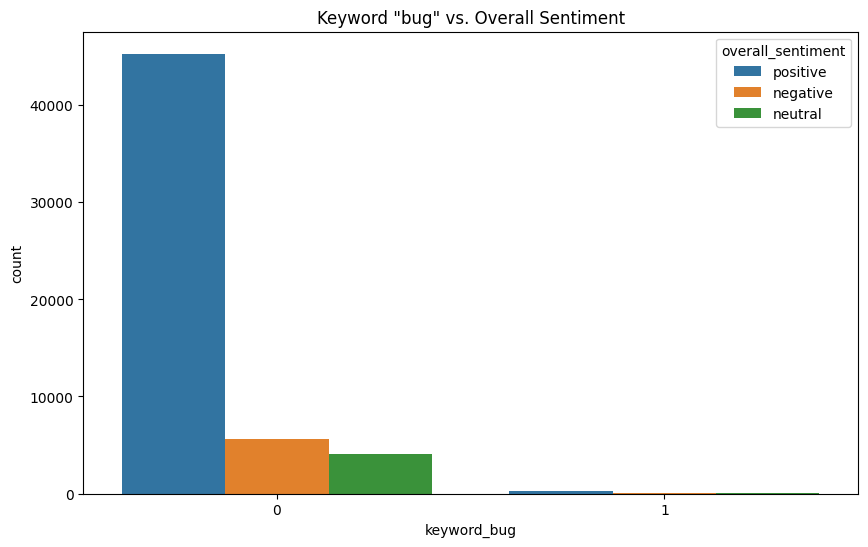

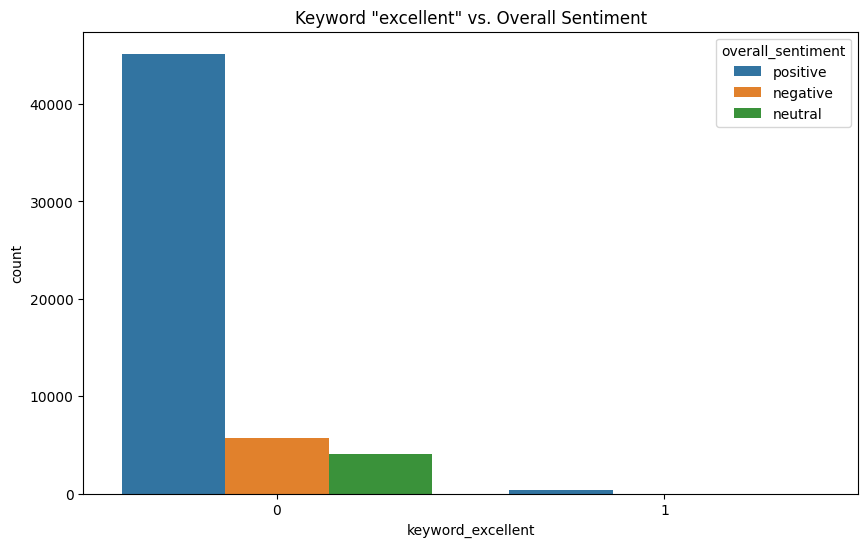

<Figure size 1200x600 with 0 Axes>

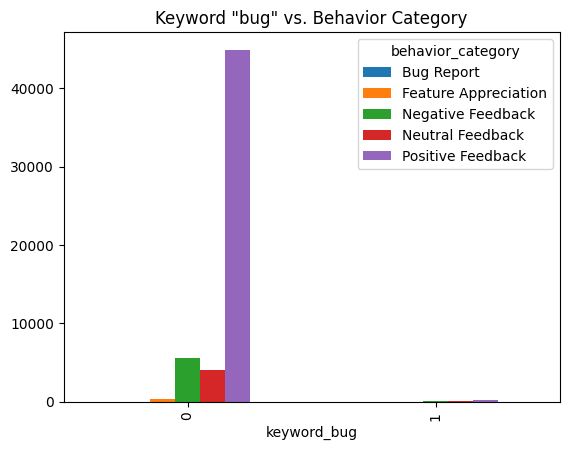

<Figure size 1200x600 with 0 Axes>

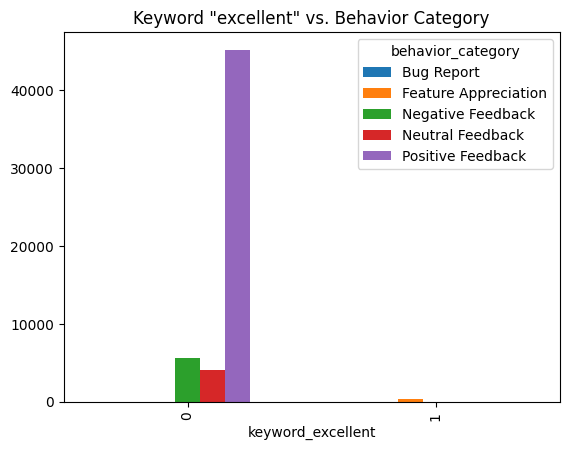

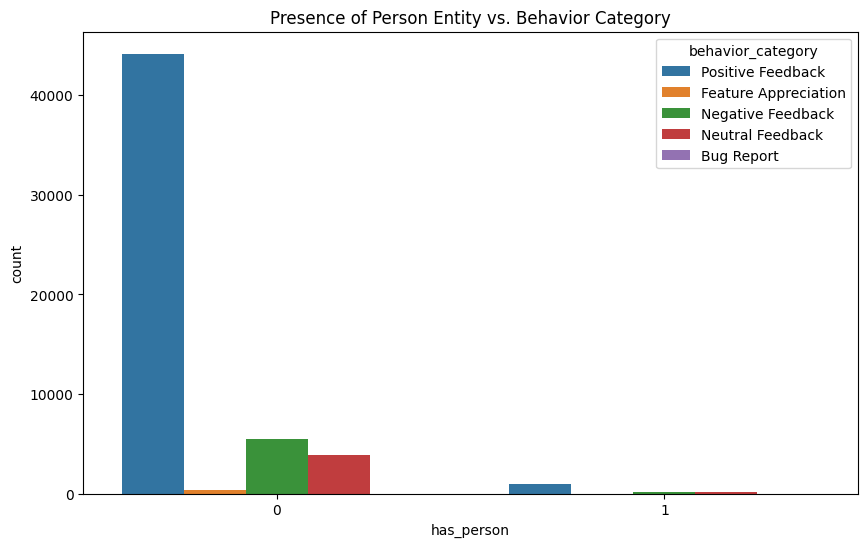

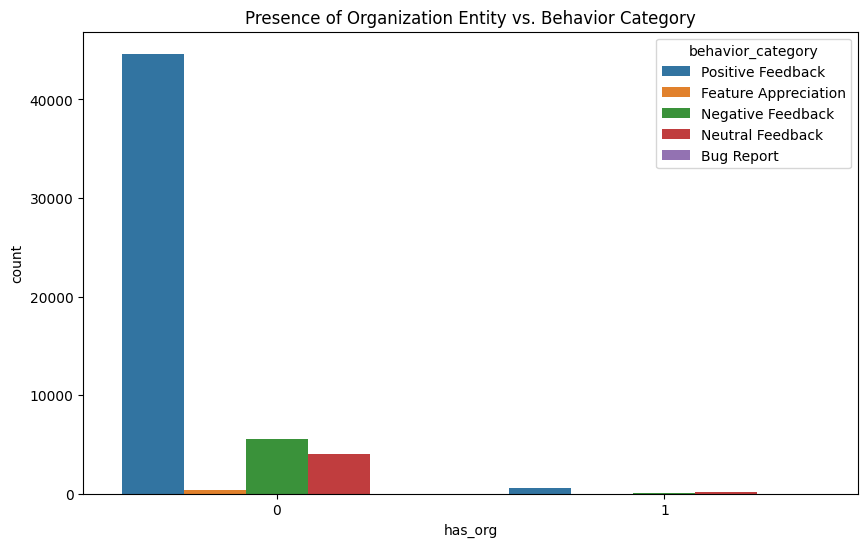

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Investigate keyword presence vs. sentiment
plt.figure(figsize=(10, 6))
sns.countplot(x='keyword_bug', hue='overall_sentiment', data=df)
plt.title('Keyword "bug" vs. Overall Sentiment')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='keyword_excellent', hue='overall_sentiment', data=df)
plt.title('Keyword "excellent" vs. Overall Sentiment')
plt.show()

# Investigate keyword presence vs. behavior category
plt.figure(figsize=(12, 6))
pd.crosstab(df['keyword_bug'], df['behavior_category']).plot(kind='bar')
plt.title('Keyword "bug" vs. Behavior Category')
plt.show()

plt.figure(figsize=(12, 6))
pd.crosstab(df['keyword_excellent'], df['behavior_category']).plot(kind='bar')
plt.title('Keyword "excellent" vs. Behavior Category')
plt.show()


#Further investigate the relationship between named entities and behavior categories
plt.figure(figsize=(10, 6))
sns.countplot(x='has_person', hue='behavior_category', data=df)
plt.title('Presence of Person Entity vs. Behavior Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='has_org', hue='behavior_category', data=df)
plt.title('Presence of Organization Entity vs. Behavior Category')
plt.show()

**Reasoning**:
Look for unusual patterns, outliers, or unexpected relationships in the data and document any observations.



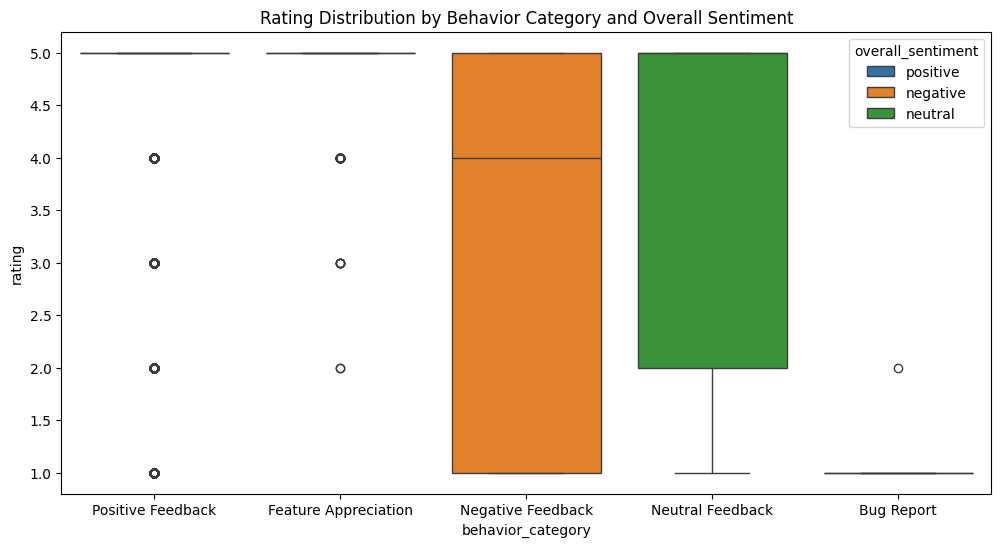

,review,rating,thumbsUp,overall_sentiment,behavior_category
0,a masterpiece mesmerizing astonishing simply p...,5,368,positive,Positive Feedback
1,seemed ok at first but the ai kept repeating t...,2,166,positive,Positive Feedback
2,this is above a five star rating and its free ...,5,399,positive,Positive Feedback
3,the best thing about it is it is free alot of ...,5,626,positive,Positive Feedback
6,this is so helpful that initially i was convi...,5,136,positive,Positive Feedback


Top 10 Keywords in Low Ratings:


,count
keywords,
help,5528
wysa,5528
really,5528
like,5528
helpful,5528
helped,5528
great,5528
good,5528
feel,5528


In [ ]:
# Investigate potential outliers in rating based on sentiment and behavior
plt.figure(figsize=(12, 6))
sns.boxplot(x='behavior_category', y='rating', hue='overall_sentiment', data=df)
plt.title('Rating Distribution by Behavior Category and Overall Sentiment')
plt.show()

# Look for reviews with very high thumbs up counts and analyze their characteristics
high_thumbs_up = df[df['thumbsUp'] > 100]
display(high_thumbs_up[['review', 'rating', 'thumbsUp', 'overall_sentiment', 'behavior_category']].head())

# Investigate any unexpected relationships between features
# Example: check if there are any specific keywords associated with low ratings
low_ratings = df[df['rating'] < 3]
low_rating_keywords = low_ratings['keywords'].explode().value_counts().head(10)
print("Top 10 Keywords in Low Ratings:")
display(low_rating_keywords)

*italicised text*## Data visualization

### Subtask:
Visualize the sentiment distribution, keyword frequencies, and named entity occurrences. Create visualizations to illustrate the identified behavioral categories.


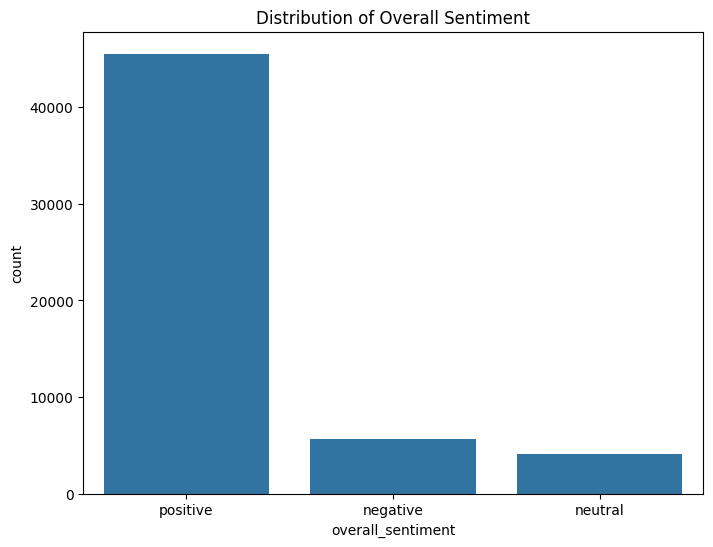

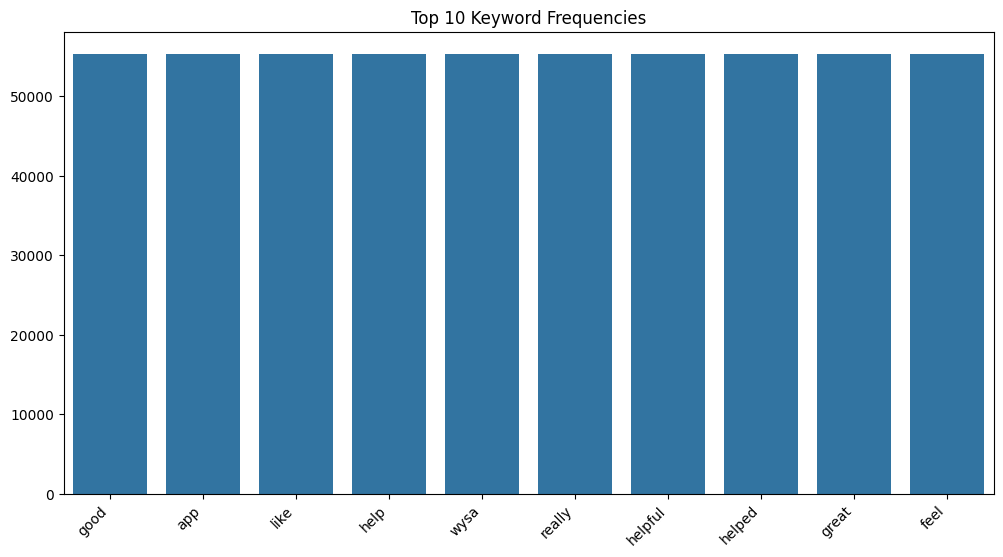

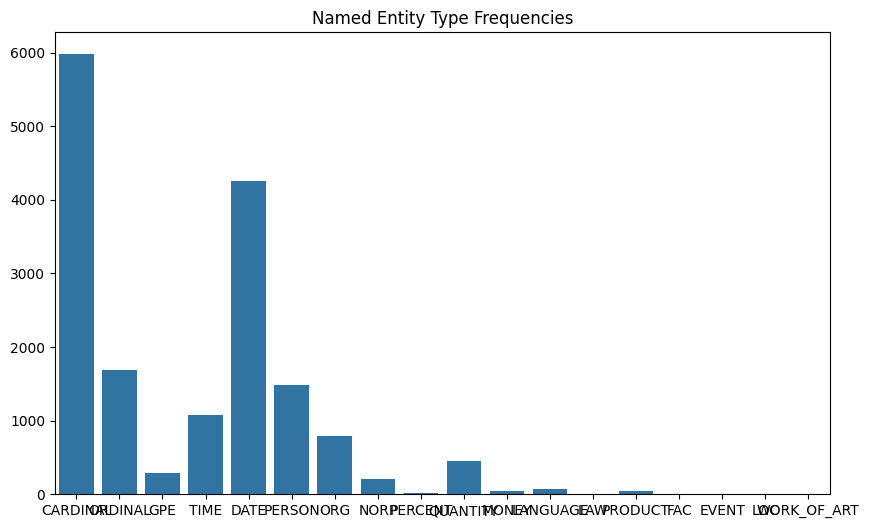

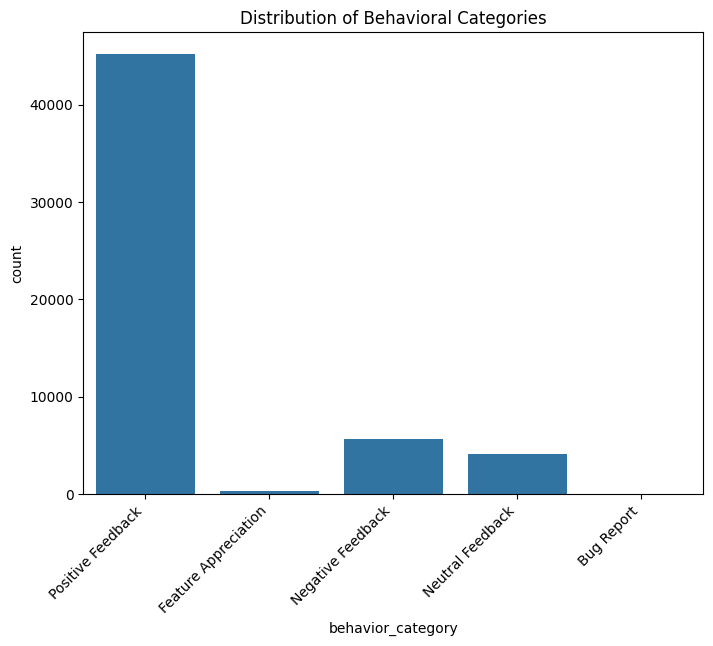

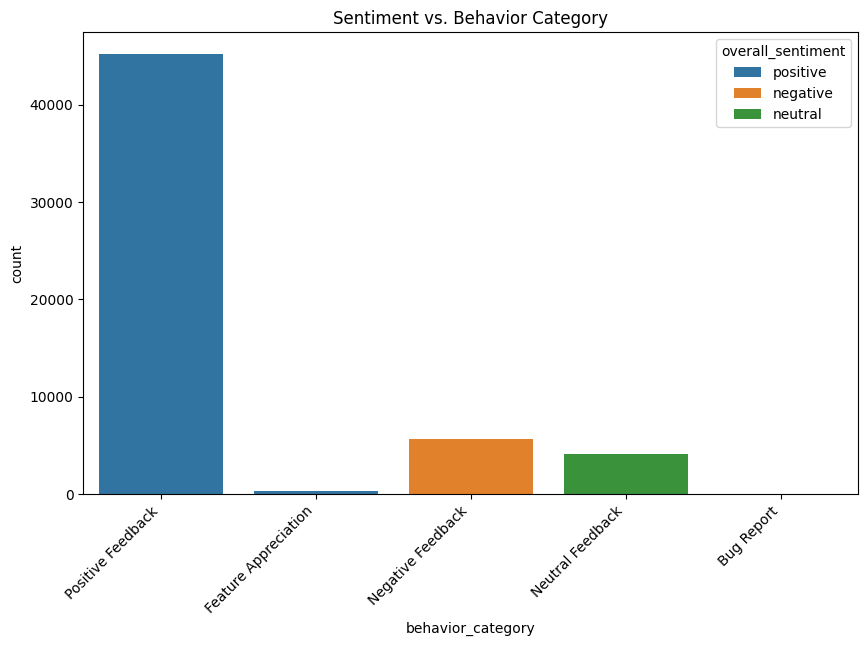

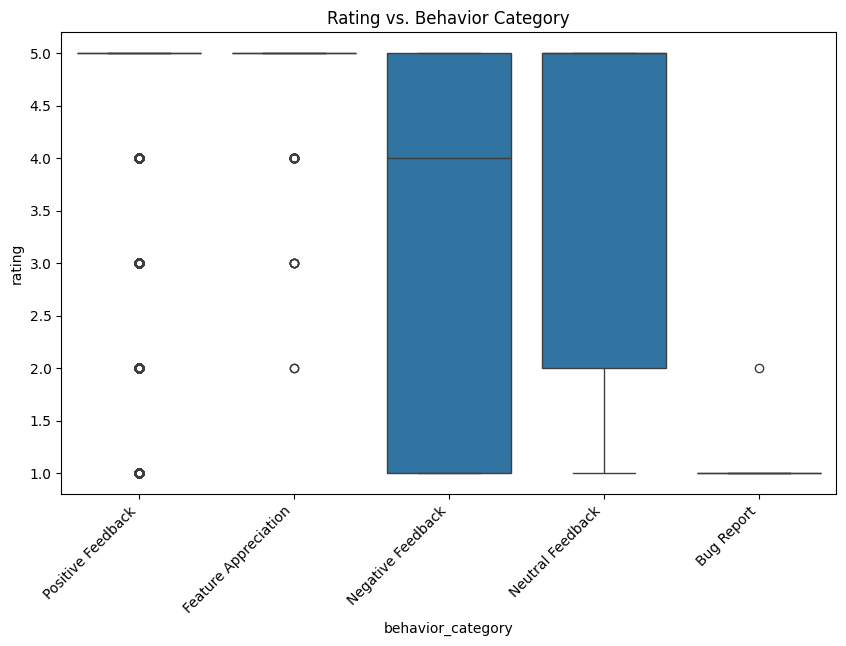

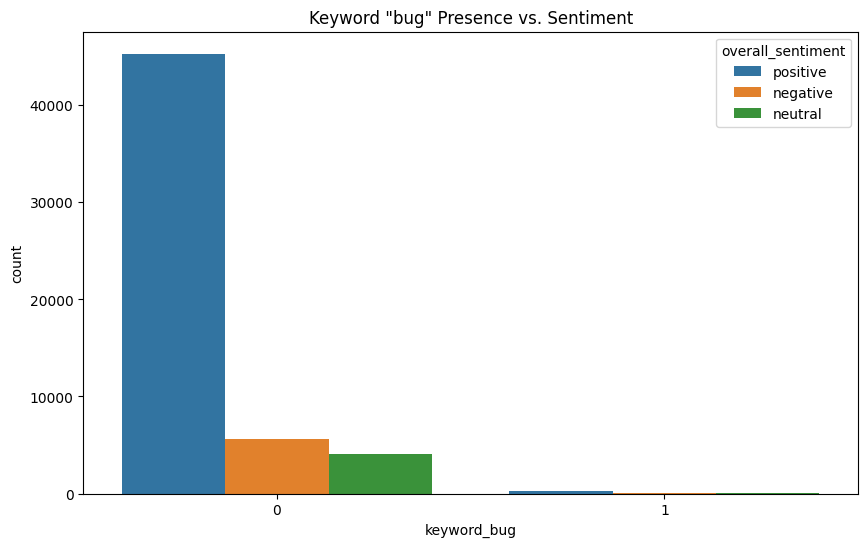

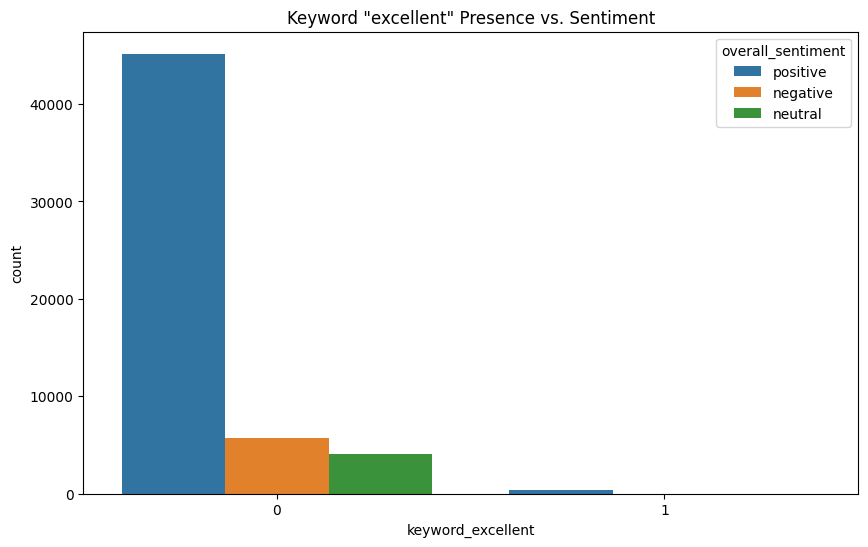

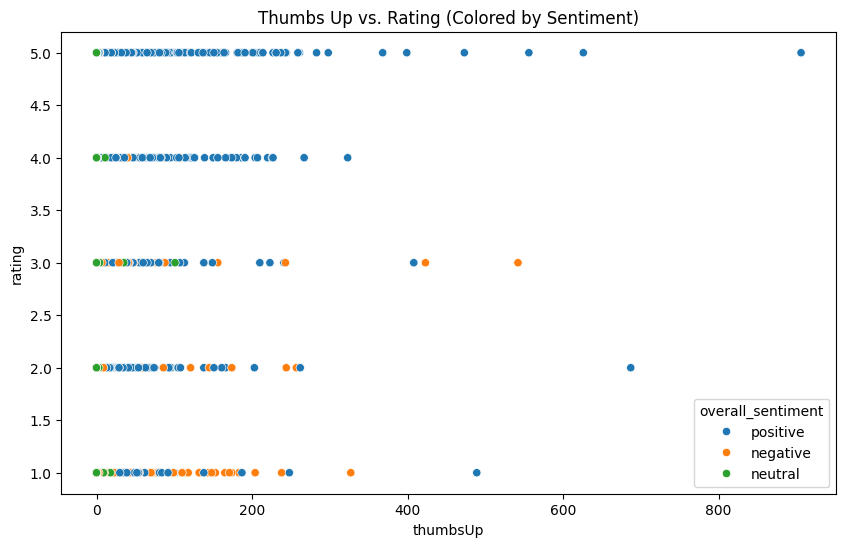

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 1. Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='overall_sentiment', data=df)
plt.title('Distribution of Overall Sentiment')
plt.show()

# 2. Keyword Frequencies
keyword_counts = Counter(keyword for keywords in df['keywords'] for keyword in keywords)
top_10_keywords = keyword_counts.most_common(10)
keywords, counts = zip(*top_10_keywords)
plt.figure(figsize=(12, 6))
sns.barplot(x=keywords, y=counts)
plt.title('Top 10 Keyword Frequencies')
plt.xticks(rotation=45, ha='right')
plt.show()


# 3. Named Entity Occurrences (Simplified - count entity types)
entity_counts = Counter(ent[1] for entities in df['named_entities'] for ent in entities)
entity_types, entity_frequencies = zip(*entity_counts.items())
plt.figure(figsize=(10, 6))
sns.barplot(x=entity_types, y=entity_frequencies)
plt.title('Named Entity Type Frequencies')
plt.show()

# 4. Behavioral Categories
plt.figure(figsize=(8, 6))
sns.countplot(x='behavior_category', data=df)
plt.title('Distribution of Behavioral Categories')
plt.xticks(rotation=45, ha='right')
plt.show()

# 5. Sentiment vs. Behavior Category
plt.figure(figsize=(10, 6))
sns.countplot(x='behavior_category', hue='overall_sentiment', data=df)
plt.title('Sentiment vs. Behavior Category')
plt.xticks(rotation=45, ha='right')
plt.show()

# 6. Rating vs. Behavior Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='behavior_category', y='rating', data=df)
plt.title('Rating vs. Behavior Category')
plt.xticks(rotation=45, ha='right')
plt.show()

# 7. Keyword Presence vs. Sentiment (Example: "bug", "excellent")
plt.figure(figsize=(10, 6))
sns.countplot(x='keyword_bug', hue='overall_sentiment', data=df)
plt.title('Keyword "bug" Presence vs. Sentiment')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='keyword_excellent', hue='overall_sentiment', data=df)
plt.title('Keyword "excellent" Presence vs. Sentiment')
plt.show()

# 8. Thumbs Up vs. Rating (colored by sentiment)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='thumbsUp', y='rating', hue='overall_sentiment', data=df)
plt.title('Thumbs Up vs. Rating (Colored by Sentiment)')
plt.show()

**bold text**## Model evaluation

### Subtask:
Evaluate the effectiveness of the keyword extraction, NER, and behavioral categorization.


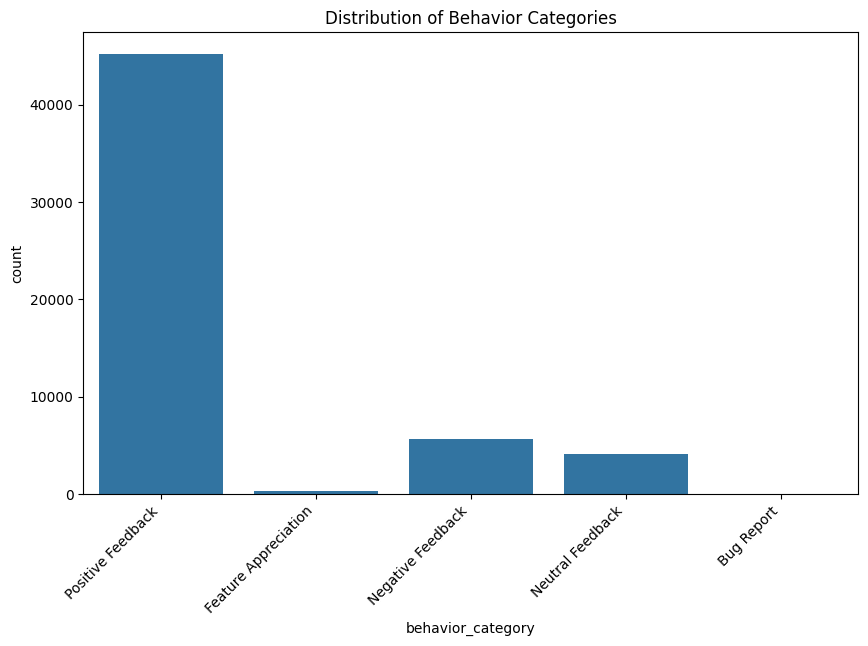

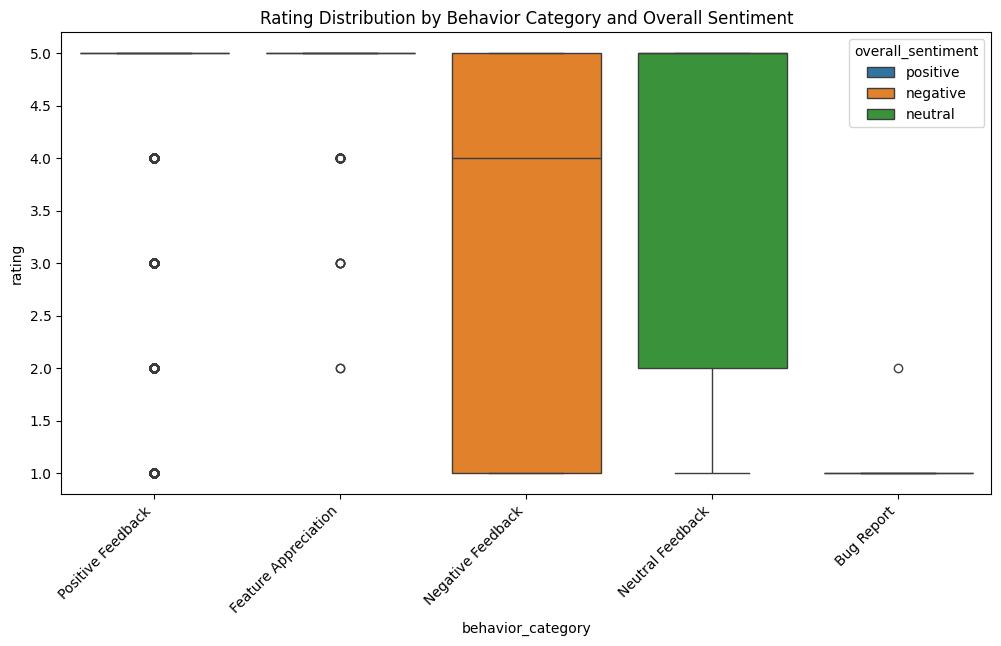

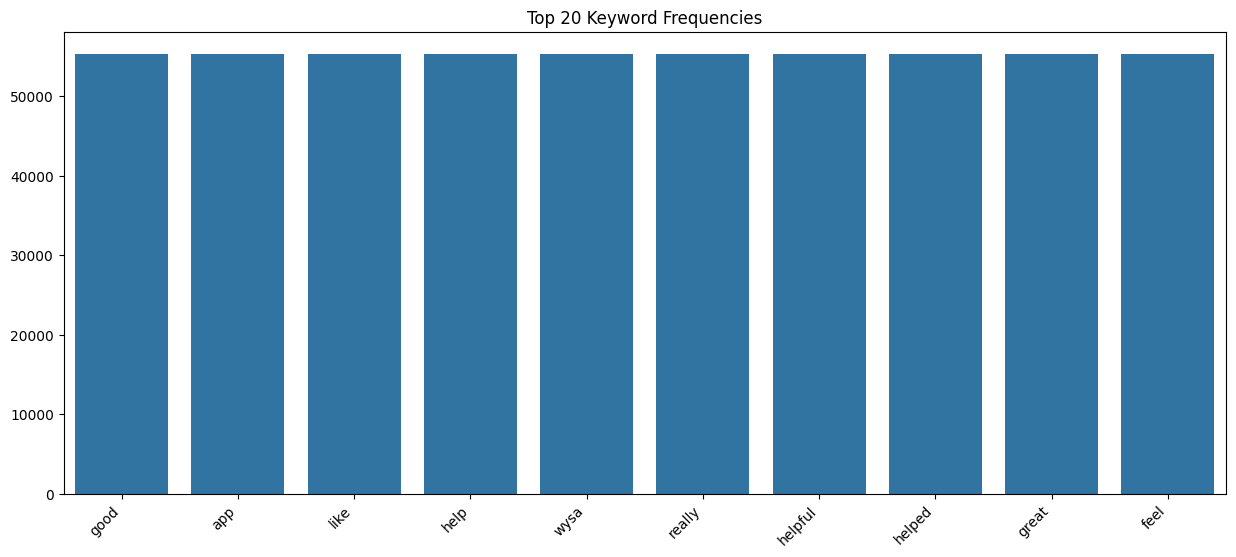

Top 10 Keywords in Low Ratings:


,count
keywords,
help,5528
wysa,5528
really,5528
like,5528
helpful,5528
helped,5528
great,5528
good,5528
feel,5528


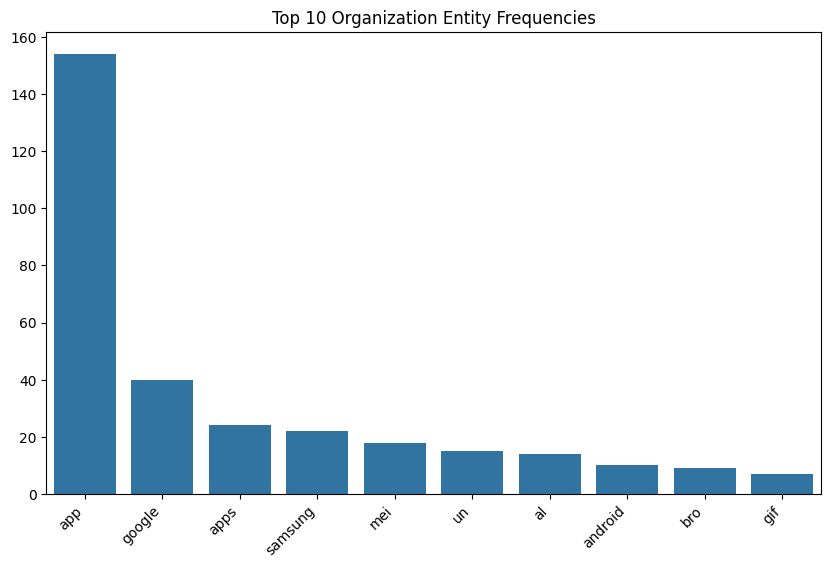

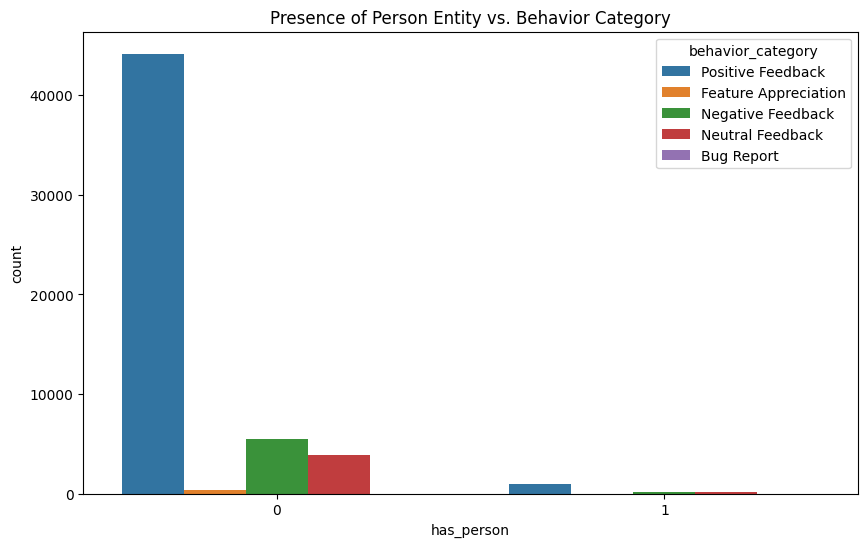

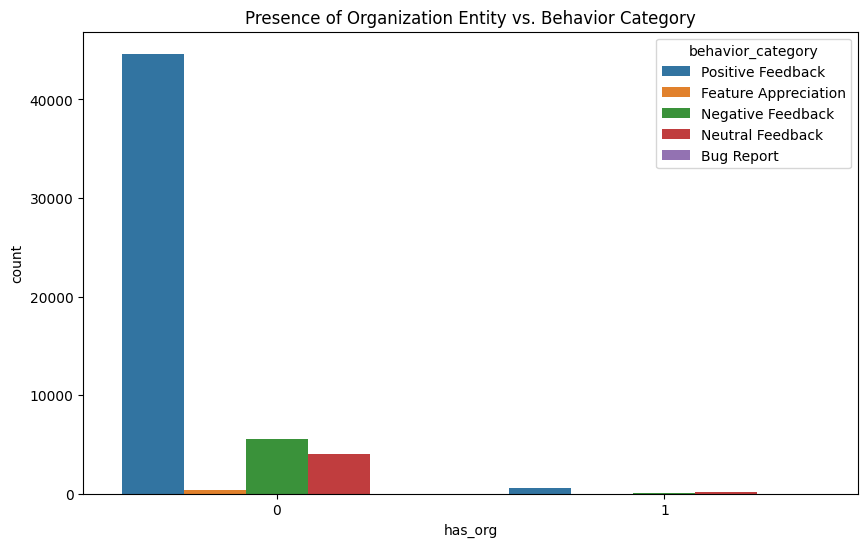

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Analyze behavior category distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='behavior_category', data=df)
plt.title('Distribution of Behavior Categories')
plt.xticks(rotation=45, ha='right')
plt.show()

# Relationship between overall_sentiment, behavior_category, and rating
plt.figure(figsize=(12, 6))
sns.boxplot(x='behavior_category', y='rating', hue='overall_sentiment', data=df)
plt.title('Rating Distribution by Behavior Category and Overall Sentiment')
plt.xticks(rotation=45, ha='right')
plt.show()

# Examine keyword relevance
keyword_counts = Counter(keyword for keywords in df['keywords'] for keyword in keywords)
top_20_keywords = keyword_counts.most_common(20)  # Increased to 20 for more comprehensive view
keywords, counts = zip(*top_20_keywords)
plt.figure(figsize=(15, 6))
sns.barplot(x=keywords, y=counts)
plt.title('Top 20 Keyword Frequencies')
plt.xticks(rotation=45, ha='right')
plt.show()

# Investigate keywords in low-rated reviews
low_ratings = df[df['rating'] < 3]
low_rating_keywords = low_ratings['keywords'].explode().value_counts().head(10)
print("Top 10 Keywords in Low Ratings:")
display(low_rating_keywords)

# Assess named entity accuracy (example: focusing on ORG entities)
org_entities = [ent[0] for entities in df['named_entities'] for ent in entities if ent[1] == 'ORG']
org_entity_counts = Counter(org_entities)
top_10_org_entities = org_entity_counts.most_common(10)
orgs, org_counts = zip(*top_10_org_entities)
plt.figure(figsize=(10, 6))
sns.barplot(x=orgs, y=org_counts)
plt.title('Top 10 Organization Entity Frequencies')
plt.xticks(rotation=45, ha='right')
plt.show()

# Review examples of misclassified reviews (optional - requires manual inspection)
# Display some samples of reviews where keywords and sentiments do not appear to match the category.
# Example: filter to find potential misclassifications
# misclassified_reviews = df[(df['behavior_category'] == 'Bug Report') & (df['overall_sentiment'] == 'positive')].sample(5)
# display(misclassified_reviews[['review', 'overall_sentiment','behavior_category','keywords']])


#Further investigate the relationship between named entities and behavior categories
plt.figure(figsize=(10, 6))
sns.countplot(x='has_person', hue='behavior_category', data=df)
plt.title('Presence of Person Entity vs. Behavior Category')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='has_org', hue='behavior_category', data=df)
plt.title('Presence of Organization Entity vs. Behavior Category')
plt.show()

## **Using NLP and Behavioral Analysis**

### Subtask:
Instead of simple keyword matching, we need a context-aware approach using NLP techniques.
Here’s how we can infer psychographic traits more accurately:



In [ ]:
psychographic_keywords = {
    "Personality": {
        "Compliant": [
            "agreeable", "submissive", "rule-following", "dutiful", "obedient",
            "cooperative", "yielding", "accommodating", "conforming", "passive"
        ],
        "Aggressive": [
            "competitive", "assertive", "dominant", "bold", "forceful",
            "ambitious", "demanding", "decisive", "challenging", "pushy"
        ],
        "Detached": [
            "reserved", "indifferent", "aloof", "isolated", "introverted",
            "unemotional", "disengaged", "detached", "independent", "self-contained"
        ]
    },
    "VALS_Traits": {
        "Consumer Innovativeness": [
            "early adopter", "risk-taker", "trendsetter", "experimenter",
            "visionary", "forward-thinking", "inventive", "progressive",
            "nonconformist", "pioneer", "open-minded", "curious"
        ],
        "Variety Seeking": [
            "novelty", "change-seeker", "explorer", "adventurous",
            "spontaneous", "versatile", "experimental", "unpredictable",
            "experience-seeker", "restless", "dynamic"
        ],
        "Dogmatism": [
            "rigid", "unwilling to change", "stubborn", "belief-driven",
            "close-minded", "traditionalist", "authoritarian", "inflexible",
            "opinionated", "resistant", "orthodox", "conservative"
        ],
        "Verbalization": [
            "expressive", "articulate", "word-oriented", "eloquent",
            "communicative", "talkative", "persuasive", "outspoken",
            "opinionated", "debater", "fluent", "well-spoken"
        ],
        "Visualization": [
            "imaginative", "pictorial thinker", "conceptual",
            "visual learner", "abstract thinker", "creative",
            "artistically inclined", "design-oriented", "symbolic thinker",
            "spatially aware"
        ],
        "Need for Cognition": [
            "analytical", "curious", "problem-solver", "critical thinker",
            "intellectual", "rational", "inquisitive", "logical",
            "information-seeker", "deep thinker", "strategic", "fact-driven"
        ],
        "Outer Directedness": [
            "peer-influenced", "social approval", "image-conscious",
            "status-seeker", "trend-follower", "validation-seeking",
            "group-oriented", "people-pleaser", "community-driven",
            "crowd-influenced"
        ],
        "Inner Directedness": [
            "self-motivated", "individualistic", "independent thinker",
            "self-reliant", "introspective", "self-aware", "autonomous",
            "self-confident", "nonconformist", "internal compass"
        ],
        "Consumer Ethnocentrism": [
            "patriotic", "local preference", "brand loyalty",
            "nationalist", "homegrown", "domestic-supporter",
            "traditionalist", "culturally-rooted", "heritage-driven"
        ],
        "Optimal Stimulation Level": [
            "thrill-seeker", "adventure-seeker", "sensation-seeking",
            "excitement-driven", "risk-loving", "bold", "daring",
            "high-energy", "adrenaline junkie", "explorer", "impulsive"
        ],
        "Materialism": [
            "possessive", "status-conscious", "luxury-driven",
            "brand-focused", "wealth-oriented", "consumerist",
            "image-conscious", "prestige-seeker", "high-spender",
            "fashion-conscious", "exclusive", "collector", "trend-driven"
        ]
    }
}


In [ ]:
from transformers import AutoTokenizer, pipeline

# Load tokenizer and model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("text-classification", model=model_name)

def classify_review(text):
    # Tokenize & truncate directly
    tokens = tokenizer.encode(text, truncation=True, max_length=512)  # Enforce strict 512 limit

    # Convert back to text
    truncated_text = tokenizer.decode(tokens, skip_special_tokens=True)

    return classifier(truncated_text)[0]['label']

df['personality_prediction'] = df['processed_review'].apply(classify_review)


Device set to use cpu


KeyboardInterrupt: 

In [ ]:
from textblob import TextBlob

def get_sentiment(review):
    sentiment = TextBlob(review).sentiment.polarity
    if sentiment > 0.5:
        return "Highly Positive"
    elif sentiment > 0:
        return "Positive"
    elif sentiment < -0.5:
        return "Highly Negative"
    else:
        return "Negative"

df['sentiment_category'] = df['processed_review'].apply(get_sentiment)


Neuroticism has low sentiment scores, these users might be more critical or frustrated.
Agreeableness has high sentiment scores, these users tend to leave positive feedback.

# No of topics : 6

In [57]:
!pip uninstall numpy
!pip install numpy==1.23.5


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/lib/python3.11/dist-packages/numpy-1.26.4.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is

In [7]:
# !pip uninstall gensim
!pip install gensim


In [8]:
import joblib
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Tokenize processed reviews
tokenized_reviews = df['processed_review'].apply(lambda x: x.split())

# Create Gensim dictionary & corpus
dictionary = Dictionary(tokenized_reviews)
corpus = [dictionary.doc2bow(text) for text in tokenized_reviews]

# Vectorize text using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_review'])
terms = vectorizer.get_feature_names_out()  # Extract words
MODEL_PATH = "pri4_lda_model.pkl"
VECTORIZER_PATH = "pri4_vectorizer.pkl"

# Train LDA Model (Sklearn)
lda_model = LatentDirichletAllocation(n_components=6, random_state=42)
lda_model.fit(X)
joblib.dump(lda_model, MODEL_PATH)
joblib.dump(vectorizer, VECTORIZER_PATH)


['pri4_vectorizer.pkl']

In [9]:
# Convert Sklearn LDA Topics → Gensim Format
lda_topics_gensim = [[terms[i] for i in topic.argsort()[-10:]] for topic in lda_model.components_]

# Compute Coherence Score
coherence_model = CoherenceModel(topics=lda_topics_gensim, texts=tokenized_reviews, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score for 6 topics: {coherence_score:.4f}")

Coherence Score for 6 topics: 0.5535


6: 0.45 <br/>
8: 0.44 <br/>
10: 0.42


In [10]:
for idx, topic in enumerate(lda_topics_gensim):
    print(f"Topic {idx}: {', '.join(topic)}")


Topic 0: track, really, time, easy, mood, great, use, health, mental, app
Topic 1: headspace, sleep, love, help, day, life, really, great, meditation, app
Topic 2: dont, like, helpful, great, help, therapist, need, good, people, app
Topic 3: wysa, like, better, amazing, love, helped, feel, help, really, app
Topic 4: little, like, care, finch, really, day, cute, help, love, app
Topic 5: use, money, work, time, pay, dont, im, subscription, free, app


In [11]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda_model, X, vectorizer)
vis


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.126653 -0.065666       1        1  21.481401
5     -0.191053  0.050931       2        1  17.494056
1      0.057074 -0.069223       3        1  17.402527
3      0.176239  0.106177       4        1  17.192542
2     -0.079006  0.118143       5        1  14.139436
0     -0.089907 -0.140362       6        1  12.290038, topic_info=             Term          Freq         Total Category  logprob  loglift
28420  meditation  14240.000000  14240.000000  Default  30.0000  30.0000
28739      mental   9346.000000   9346.000000  Default  29.0000  29.0000
21493      health   8631.000000   8631.000000  Default  28.0000  28.0000
21743      helped  17298.000000  17298.000000  Default  27.0000  27.0000
11999        cute  11225.000000  11225.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
50551        work   1441.476007  10146.772402   Topic6  -5.3102   0.1449
20073        good   1601.351178  22537.994426   Topic6  -5.2050  -0.5480
12334         day   1548.146561  21780.264826   Topic6  -5.2388  -0.5476
48576       using   1342.770459   9307.946197   Topic6  -5.3811   0.1602
27790        make   1269.112635  15076.396762   Topic6  -5.4375  -0.3784

[521 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
53         1  0.002452     10
53         2  0.207229     10
53         3  0.777824     10
53         5  0.002044     10
53         6  0.010218     10
...      ...       ...    ...
51345      2  0.093933  youre
51345      3  0.104081  youre
51345      4  0.097123  youre
51345      5  0.436616  youre
51345      6  0.050736  youre

[1301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 2, 4, 3, 1])

In [12]:
# Get topic distributions for each review
topic_distributions = lda_model.transform(X)

# Convert to DataFrame
topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i}" for i in range(lda_model.n_components)])
topic_df['app_id'] = df['app_id']  # Assuming 'app_id' column exists

# Group by app_id and compute average topic distribution
app_topics = topic_df.groupby('app_id').mean()

# Assign dominant topic to each app_id
app_topics['Dominant_Topic'] = app_topics.idxmax(axis=1)

# Display results
print(app_topics[['Dominant_Topic']])

                                   Dominant_Topic
app_id                                           
app.lovewise                              Topic 3
app.mindshine                             Topic 2
app.voicestories.android                  Topic 1
betwixt.web.app                           Topic 3
bot.touchkin                              Topic 3
co.mindpeers                              Topic 3
com.bearable                              Topic 2
com.betterhelp                            Topic 2
com.cbt.mindhealthy                       Topic 4
com.eastfrisia.airelationshipcoach        Topic 2
com.finch.finch                           Topic 4
com.gen.bettermeditation                  Topic 5
com.getmental.mental                      Topic 2
com.getsomeheadspace.android              Topic 1
com.lasting.lasting                       Topic 3
com.magi.closer                           Topic 3
com.museLIVE.quabbleapp                   Topic 0
com.remente.app                           Topic 1


In [13]:
app_topics[['Dominant_Topic']].to_csv("app_topics.csv", index=True)
